## Import dependencies

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms

In [3]:
from training.utils import get_device, print_cuda_info
from training.data_prep import load_data

## Load and prepare data

In [4]:
print_cuda_info()

CUDA Available? True


In [5]:
input_image_size = (28, 28)
train_data, test_data = load_data(train_transforms=[
     # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
        transforms.Resize(input_image_size),
        # transforms.RandomRotation((-7., 7.), fill=0),
])

In [6]:
from training.model_trainer import ModelTrainer

trainer = ModelTrainer()

trainer.init_data_loaders(train_data, test_data, batch_size=512,
                          shuffle=True, num_workers=2, pin_memory=True)

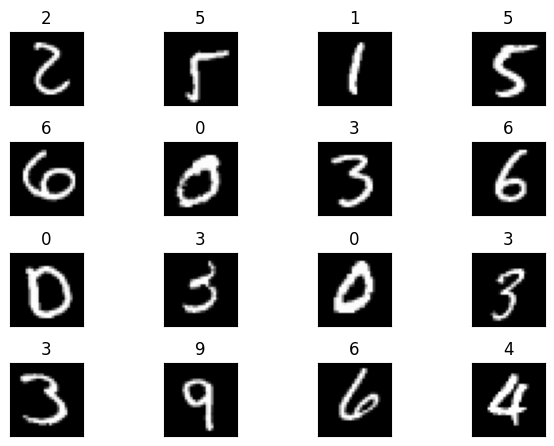

In [7]:
trainer.show_sample_images_from_dataset(4,4)

## Load Model

In [8]:
from models.model_1 import Net
device = get_device()

model = Net().to(device)
summary(model, input_size=(1,*input_image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,856
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           2,064
            Conv2d-9             [-1, 32, 9, 9]           4,640
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 5, 5]          73,856
             ReLU-14            [-1, 12

/content/models/model_1.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Start training

In [9]:
device = torch.cuda.current_device()
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 15

trainer.run_training(model, device, optimizer, criterion, scheduler, num_epochs)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.3000 Batch_id=117 Accuracy=10.91: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 2.2938, Accuracy: 1135/10000 (11.35%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.9983 Batch_id=117 Accuracy=27.50: 100%|██████████| 118/118 [00:16<00:00,  7.25it/s]


Test set: Average loss: 1.0030, Accuracy: 6475/10000 (64.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1701 Batch_id=117 Accuracy=83.38: 100%|██████████| 118/118 [00:16<00:00,  7.02it/s]


Test set: Average loss: 0.1948, Accuracy: 9387/10000 (93.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0861 Batch_id=117 Accuracy=95.53: 100%|██████████| 118/118 [00:16<00:00,  7.17it/s]


Test set: Average loss: 0.1044, Accuracy: 9671/10000 (96.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0591 Batch_id=117 Accuracy=97.05: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0832, Accuracy: 9737/10000 (97.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0884 Batch_id=117 Accuracy=97.71: 100%|██████████| 118/118 [00:16<00:00,  7.10it/s]


Test set: Average loss: 0.0650, Accuracy: 9790/10000 (97.90%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0572 Batch_id=117 Accuracy=98.23: 100%|██████████| 118/118 [00:16<00:00,  7.01it/s]


Test set: Average loss: 0.0603, Accuracy: 9806/10000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0844 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:16<00:00,  7.28it/s]


Test set: Average loss: 0.0494, Accuracy: 9836/10000 (98.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0690 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:16<00:00,  7.01it/s]


Test set: Average loss: 0.0578, Accuracy: 9819/10000 (98.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0911 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:16<00:00,  7.19it/s]


Test set: Average loss: 0.0482, Accuracy: 9856/10000 (98.56%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0026 Batch_id=117 Accuracy=99.31: 100%|██████████| 118/118 [00:16<00:00,  7.00it/s]


Test set: Average loss: 0.0349, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0343 Batch_id=117 Accuracy=99.44: 100%|██████████| 118/118 [00:16<00:00,  7.13it/s]


Test set: Average loss: 0.0346, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0050 Batch_id=117 Accuracy=99.47: 100%|██████████| 118/118 [00:16<00:00,  7.01it/s]


Test set: Average loss: 0.0337, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0243 Batch_id=117 Accuracy=99.50: 100%|██████████| 118/118 [00:16<00:00,  7.15it/s]


Test set: Average loss: 0.0349, Accuracy: 9883/10000 (98.83%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0036 Batch_id=117 Accuracy=99.51: 100%|██████████| 118/118 [00:16<00:00,  6.98it/s]


Test set: Average loss: 0.0351, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-03.


## Analyze Results

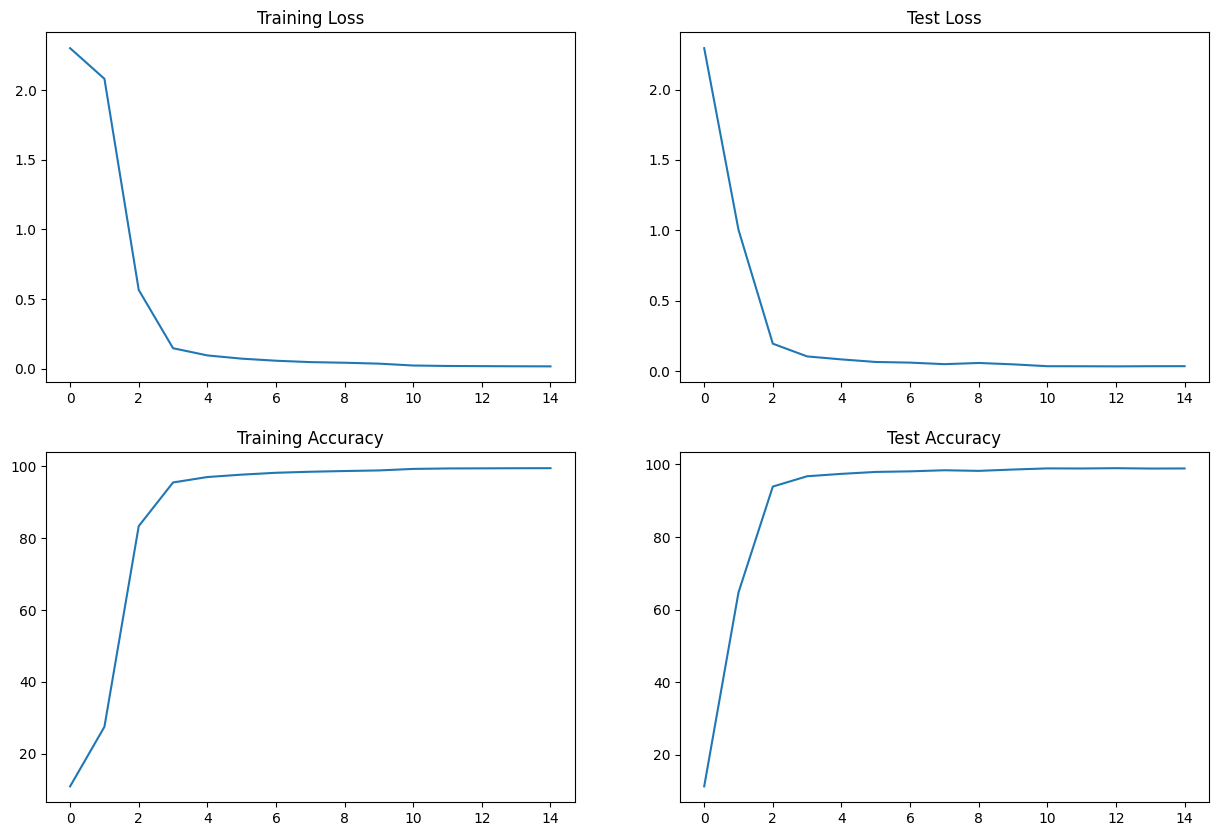

In [10]:
trainer.plot_accuracy_and_loss(fig_size=(15, 10))

In [11]:
# Target:
#   Set up a basic working model that reaches 99% train accuracy in 15 epochs
# Results:
#   Parameters: 509,946
#   Best train accuracy: 99.51
#   Best test accuracy: 98.93
# Analysis:
#   Heavy model and converges slowly.
#   The model seems like a good starting point and is overfitting from 8th epoch